In [1]:
import numpy as np
def diffusion_kalman_filter(psi, x_hat, P, N, H, R, y, A, Q, W, num_steps):
    num_nodes = len(x_hat)

    for k in range(num_steps):
        # Measurement Sharing and Update Step
        for i in range(num_nodes):
            psi_i = psi[i]
            P_i = P[i]

            for j in N[i]:
                # Compute Kalman gain
                Sij = H[j] @ P_i @ H[j].T + R[j]
                Kij = P_i @ H[j].T @ np.linalg.inv(Sij)

                # Update state estimate
                t_j = y[j] - H[j] @ psi_i
                psi_i = psi_i + Kij @ t_j

                # Update error covariance
                P_i = (np.eye(P_i.shape[0]) - Kij @ H[j]) @ P_i

            psi[i] = psi_i
            P[i] = P_i

        # Estimate Sharing Step
        new_x_hat = [None] * num_nodes
        for i in range(num_nodes):
            new_x_hat[i] = W[i, i] * psi[i] + sum(W[i, j] * psi[j] for j in N[i])

        x_hat = new_x_hat

        # Prediction Step
        for i in range(num_nodes):
            psi[i] = A @ x_hat[i]
            P[i] = A @ P[i] @ A.T + Q

    return psi, x_hat, P

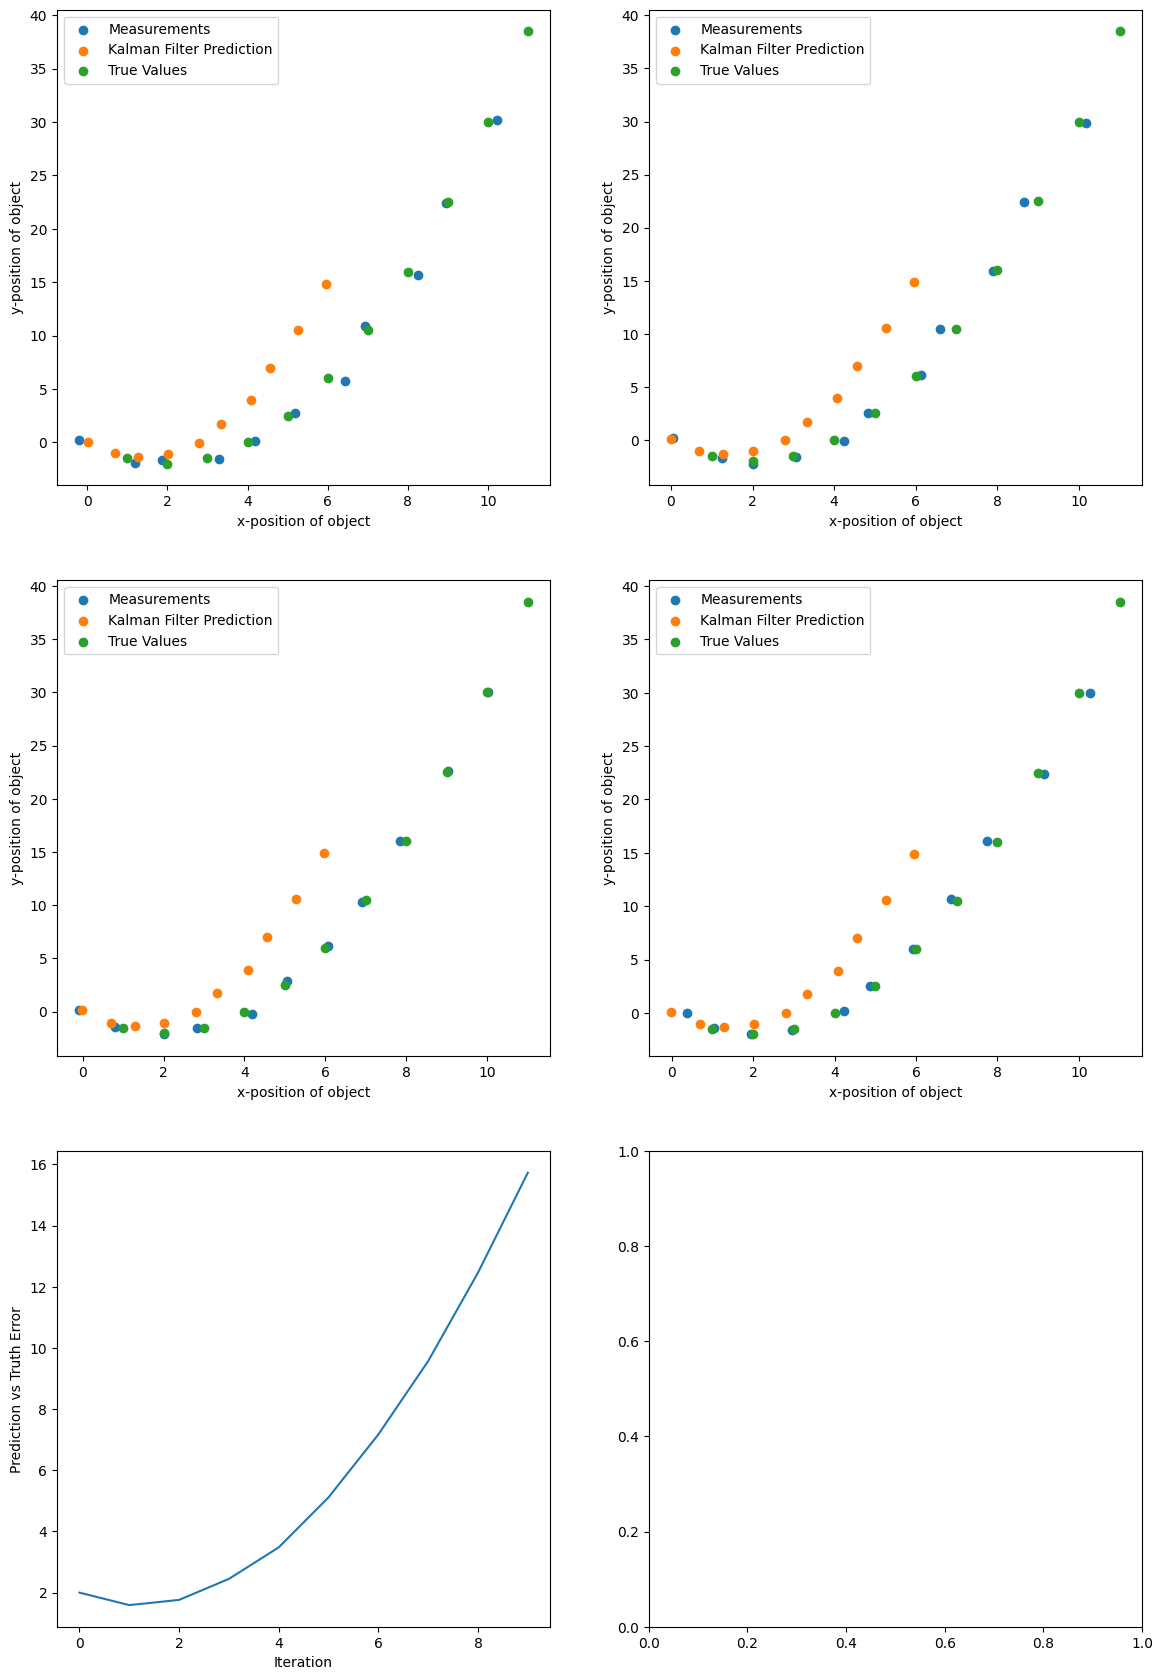

In [2]:
import matplotlib.pyplot as plt

np.random.seed(163)

def example():
    C = np.array([[0.34, 0.33, 0.33, 0], [0.33, 0.34, 0, 0.33], [0.33, 0, 0.34, 0.33], [0, 0.33, 0.33, 0.34]])
    n = len(C[0])

    A = np.array([[1, 1, 0.5, 0, 0, 0],
                  [0, 1, 1, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 1, 0.5],
                  [0, 0, 0, 0, 1, 1],
                  [0, 0, 0, 0, 0, 1]])

    H = [np.array([[1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]) for _ in range(n)]
    Q = np.diag([0.05] * 6)
    R = [np.diag([0.04, 0.04]) for _ in range(n)]

    # true initial state
    xp = np.array([[0, 1, 0, 0, -2, 1]]).T

    # random initial estimates for each node
    x0 = [np.random.normal(0, 5, (6, 1)) for _ in range(n)]

    P = [np.eye(6) for _ in range(n)]

    # Define the neighbor list
    N = [[1, 3], [0, 2], [1, 3], [0, 2]]

    # Measurement noise
    measure_var = 0.2
    z = [(H[i] @ xp) + np.random.normal(0, measure_var, (2, 1)) for i in range(n)]

    truth = [A @ xp]
    predictions = {i: [] for i in range(n)}
    measurements = [z]
    errors = []

    psi = x0.copy()
    x_hat = x0.copy()

    for i in range(10):
        psi, x_hat, P = diffusion_kalman_filter(psi, x_hat, P, N, H, R, z, A, Q, C, 1)

        for j in range(n):
            predictions[j].append(H[j] @ x_hat[j])

        z = [(H[i] @ truth[-1]) + np.random.normal(0, measure_var, (2, 1)) for i in range(n)]
        truth.append(A @ truth[-1])
        measurements.append(z)
        errors.append(np.mean([np.linalg.norm(H[j] @ x_hat[j] - z[j]) for j in range(n)]))

    fig, axs = plt.subplots(((n + 2) // 2), 2, figsize=(14, 7 * ((n + 2) // 2)))
    for i in range(n):
        axs[i // 2][i % 2].scatter([x[i][0, 0] for x in measurements], [x[i][1, 0] for x in measurements], label='Measurements')
        axs[i // 2][i % 2].scatter([x[0, 0] for x in predictions[i]], [x[1, 0] for x in predictions[i]], label='Kalman Filter Prediction')
        axs[i // 2][i % 2].scatter([(H[i] @ x)[0, 0] for x in truth], [(H[i] @ x)[1, 0] for x in truth], label='True Values')
        axs[i // 2][i % 2].set_xlabel("x-position of object")
        axs[i // 2][i % 2].set_ylabel("y-position of object")
        axs[i // 2][i % 2].legend()

    axs[n // 2][n % 2].set_xlabel("Iteration")
    axs[n // 2][n % 2].set_ylabel("Prediction vs Truth Error")
    axs[n // 2][n % 2].plot(range(len(errors)), errors, label='Prediction vs Truth Error')
    plt.show()

example()